**SUPERCOMPUTAÇÃO - AVALIAÇÃO FINAL - 13/06/2022**

**NOME:** Matheus Freitas Sant'Ana

#### Imports necessários

In [423]:
import subprocess
import time
import os
import sys
import matplotlib.pyplot as plt
import random
import statistics
import numpy as np
import pandas as pd

**QUESTÃO 1.** Resolva a questão 1 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

#### Função para rodar o executável e calcular o tempo 

In [424]:
def roda_com_entrada(executavel, arquivo_in):
    with open(arquivo_in) as f:
        start = time.perf_counter()
        proc = subprocess.run([executavel], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()

        # print('Saída:', proc.stdout)
        # print('Stderr:', proc.stderr)
        # print('Tempo total(s):', end - start)
        f.close()
    return (proc.stdout, end - start)

#### Função para gerar entradas

In [425]:
def gerador_entrada(a, b):
  f = open(f'./in.txt', 'w')
  line = str(a) + ' ' + str(b)
  f.writelines(line)
  f.close()     

#### Código e geração de executável

In [426]:
%%writefile Questao1.cpp

#include<iostream>
#include<random>
#include<omp.h>
#include<math.h>
using namespace std;

#define MULT 100000

int main() {
    int N, num_threads;
    double sum = 0.0;

    cin >> N;
    vector<int> vec(N, 0);

    cin >> num_threads;

    omp_set_num_threads(num_threads);
    #pragma omp parallel for reduction(+:sum)
    for(int i = 0; i < N; i++) {
        #pragma omp critical
        {
            // Multiplicamos por MULT para obter números mais aleatórios
            default_random_engine generator(i*MULT);
            uniform_int_distribution<int> distribution(1, 199);
            vec[i] = distribution(generator); 
            sum += vec[i];
        }
    }

   for(int i = 0; i < N; i++) {
    cout << vec[i] << endl;
   }

   double mean = sum/N;
   double var = 0.0;

   #pragma omp parallel for reduction(+:var)
   for(int i = 0; i < N; i++) {
    var += pow(vec[i] - mean, 2);
   }

   var /= N;

   cout << "Média: " << mean << endl;
   cout << "Variância: " << var << endl;
   
    return 0;
}

Writing Questao1.cpp


Observações sobre o código: Foi necessário utilizar a região crítica, pois como ela faz com que a região rode em uma thread por vez, isso faz com que elas tenham diferentes seeds para gerar números aleatórios. Caso não houvesse essa região crítica, os números gerados aleatoriamente por cada thread correm o risco de serem os mesmos. Por isso, mesmo que essa ação é muito cara para o desempenho, ela se faz necessária para que se obtenha resultados mais confiáveis. Além disso, para obter seeds diferentes a cada iteração, foi utilizado o próprio iterador `i`  como semente, sendo que ele também é multiplicado por um valor alto, pois seeds próximos geram sequências que são inicialmente parecidas e depois diferem (e queremos "maximizar" a aleatoridade).

In [427]:
!g++ -Wall -g -O3 -fopenmp Questao1.cpp -o Questao1

#### Rodando executáveis com entradas e número de threads diferentes

In [428]:
tamanhos_q1_2threads = []
tempos_q1_2threads = []

tamanhos_q1_3threads = []
tempos_q1_3threads = []

tamanhos_q1_5threads = []
tempos_q1_5threads = []

tamanhos_q1_7threads = []
tempos_q1_7threads = []

tamanhos_q1_9threads = []
tempos_q1_9threads = []

total = 50
n = 5
num_threads = 2

for i in range(0, total):
    gerador_entrada(n, num_threads)
    tempos_q1_2threads.append(roda_com_entrada('./Questao1', './in.txt')[1])
    tamanhos_q1_2threads.append(n)

    gerador_entrada(n, num_threads + 1)
    tempos_q1_3threads.append(roda_com_entrada('./Questao1', './in.txt')[1])
    tamanhos_q1_3threads.append(n)

    gerador_entrada(n, num_threads + 3)
    tempos_q1_5threads.append(roda_com_entrada('./Questao1', './in.txt')[1])
    tamanhos_q1_5threads.append(n)

    gerador_entrada(n, num_threads + 5)
    tempos_q1_7threads.append(roda_com_entrada('./Questao1', './in.txt')[1])
    tamanhos_q1_7threads.append(n)

    gerador_entrada(n, num_threads + 7)
    tempos_q1_9threads.append(roda_com_entrada('./Questao1', './in.txt')[1])
    tamanhos_q1_9threads.append(n)

    n+= 500

#### Gerando gráfico de comparação de desempenho

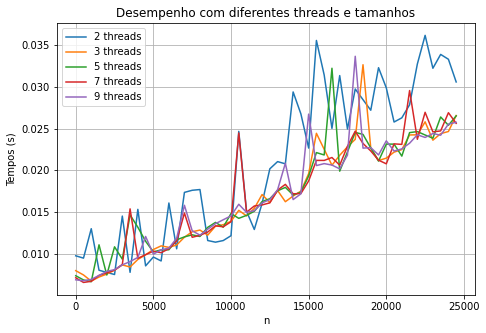

In [429]:
plt.figure(figsize=(7.5, 5))
plt.plot(tamanhos_q1_2threads, tempos_q1_2threads, label='2 threads')
plt.plot(tamanhos_q1_3threads, tempos_q1_3threads, label='3 threads')
plt.plot(tamanhos_q1_5threads, tempos_q1_5threads, label='5 threads')
plt.plot(tamanhos_q1_7threads, tempos_q1_7threads, label='7 threads')
plt.plot(tamanhos_q1_9threads, tempos_q1_9threads, label='9 threads')
plt.title('Desempenho com diferentes threads e tamanhos')
plt.xlabel('n')
plt.ylabel('Tempos (s)')
plt.grid('on')
plt.legend()
plt.show()

A partir do gráfico, fica evidente que o pior desempenho apresentado é quando o código roda com duas threads apenas, enquanto que os melhores desempenhos são dos códigos que utilizaram um número maior de threads. No entanto, conforme o número de threads aumenta, parece que essa diferença vai diminuindo, ou seja, atinge um ponto de "saturação" em que não adianta mais aumentar o número de threads pois não haverá ganho significativo de desempenho, e aumentar o número de threads é um processo caro. Vale ressaltar que se não existisse esse controle de número de threads, o código iria apresentar um desempenho inferior, já que muitas sequências pseudo-aleatórias iriam ser geradas e nenhuma delas seriam válidas (e com uma limitação temos `NUM_THREADS`  sequências válidas).

**FEEDBACK QUESTÃO 1**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

**QUESTÃO 2.** Resolva a questão 2 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

#### Função para gerar entradas arquivo input com 3 valores

In [430]:
def gerador_entrada_q2(a, b, c):
  f = open(f'./in.txt', 'w')
  line = str(a) + ' ' + str(b) + ' ' + str(c)
  f.writelines(line)
  f.close()  

#### 1. Versão Saxpy com OpenMP (8 threads por padrão)

#### Código e geração de executável

In [431]:
%%writefile Questao2.cpp

#include<iostream>
#include<random>
#include<omp.h>
#include <iomanip>
#include<vector>
#include<math.h>
using namespace std;

#define MULT 100000

double saxpy(int a, int x, int y) {
    return a * x + y;
}

int main() {
    int n, m, num_threads;

    cin >> n >> m >> num_threads;

    vector<int> a(n);
    vector<int> b(n);
    vector<int> c(n);

    // Multiplicamos por MULT para obter números mais aleatórios
    default_random_engine generator(10*MULT);
    uniform_int_distribution<int> distribution(1, 100000);

    omp_set_num_threads(num_threads);
    #pragma omp parallel shared(generator)
    {
        for(int i = 0; i < n; i++) {
            #pragma omp master
            {
                #pragma omp task 
                {
                    a[i] = distribution(generator);
                }
                #pragma omp task 
                {
                    b[i] = distribution(generator);
                }
            }
        }
    }

    
    #pragma omp parallel for
    for(int i = 0; i < n; i++) {
        c[i] = saxpy(m, a[i], b[i]);
    }

    for (int i = 0; i < n; i++ )
        cout << setw(6) << c[i] << " = " 
          << setw(2) << m
          << "*" << setw(5) << a[i]
          << "+" << setw(5) << b[i]
          << endl;


    return 0;
}

Writing Questao2.cpp


Observações sobre o código: a seção do código responsável por gerar os números aleatórios e preenchê-los nos vetores `a`  e `b`   pôde ser paralelizada por meio da criação de uma região paralelizada em que o gerador de números aleatórios é uma variável compartilhada entre as threads. Como a tarefa de gerar números aleatórios é heterogênea, ou seja, é desejado que números diferentes sejam gerados para `a`  e `b`  , foi necessário o uso de tasks para atingir esse objetivo. Caso não houvessem tasks, os dois vetores ficariam idênticos (e se a variável `generator`  não fosse compartilhada esse também seria o caso).

In [432]:
!g++ -Wall -g -O3 -fopenmp Questao2.cpp -o Questao2

#### Exemplo de input e output

In [433]:
gerador_entrada_q2(5, 3, 8)
!./Questao2 < in.txt

261116 =  3*82641+13193
268675 =  3*78818+32221
132853 =  3*23743+61624
127592 =  3*18634+71690
211356 =  3*40586+89598


#### 2. OpenMP vs GPU

#### Código e geração de executável (GPU)

In [434]:
 %%writefile Questao2-GPU.cu
 
 #include <thrust/host_vector.h>
 #include <thrust/device_vector.h>
 #include <thrust/generate.h>
 #include <thrust/functional.h>
 #include <thrust/copy.h>
 #include <cstdlib>
 #include <algorithm>
 #include <iostream>
 #include <iomanip>

 using namespace  std;

struct saxpy
{
    int a;    
    saxpy(int a_) : a(a_) {};
    __host__ __device__
    double operator()(const int& x, const int& y) {
           return a * x + y;
    }
};

int main() {
     int n, m;
     cin >> n >> m;
     

     //gerar numeros aleatorios
     thrust::host_vector<int> a(n);
     thrust::host_vector<int> b(n);
     thrust::host_vector<int> c(n);
     thrust::generate(a.begin(), a.end(), rand);
     thrust::generate(b.begin(), b.end(), rand);

     //transferimos para a GPU
     thrust::device_vector<int> d_a = a;
     thrust::device_vector<int> d_b = b;

     //transformacao

     thrust::transform(d_a.begin(), d_a.end(),
                       d_b.begin(), d_b.end(),
                       saxpy(m));

     thrust::copy(d_b.begin(), d_b.end(),
     c.begin()); 

     for (int i = 0; i < n; i++ )
         cout << setw(6) << c[i] << " = " 
          << setw(2) << m
          << "*" << setw(5) << a[i]
          << "+" << setw(5) << b[i]
          << endl;

}


Writing Questao2-GPU.cu


In [435]:
!nvcc -Wno-deprecated-gpu-targets -arch=sm_37 -std=c++14 -o Questao2-GPU Questao2-GPU.cu

#### Exemplo de input e output

In [436]:
gerador_entrada(5, 3)
!./Questao2-GPU < in.txt

424238335 =  3*1804289383+424238335
719885386 =  3*846930886+719885386
1649760492 =  3*1681692777+1649760492
596516649 =  3*1714636915+596516649
1189641421 =  3*1957747793+1189641421


In [437]:
tempos_OP = []
tamanhos_OP = []

tempos_GPU = []
tamanhos_GPU = []

total = 50
n = 5
m = 3 # Valor arbitrário
for i in range(0, total):
  gerador_entrada_q2(n, m, 8)
  tempos_OP.append(roda_com_entrada('./Questao2', './in.txt')[1])
  tamanhos_OP.append(n)

  gerador_entrada(n, m)
  tempos_GPU.append(roda_com_entrada('./Questao2-GPU', './in.txt')[1])
  tamanhos_GPU.append(n)

  n += 5000

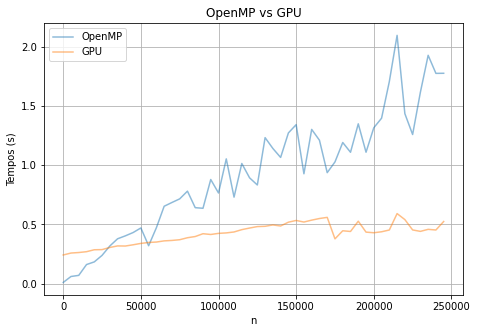

In [438]:
plt.figure(figsize=(7.5, 5))
plt.plot(tamanhos_OP, tempos_OP, label='OpenMP', alpha = 0.5)
plt.plot(tamanhos_GPU, tempos_GPU, label='GPU', alpha = 0.5)
plt.title('OpenMP vs GPU')
plt.xlabel('n')
plt.ylabel('Tempos (s)')
plt.grid('on')
plt.legend()
plt.show()

Como pode-se observar no gráfico, apesar do OpenMP conseguir se sobressair para valores de `n`  pequenos, a GPU tem um desempenho em geral muito superior conforme a entrada aumenta. Para investigar o porquê disso ocorrer, é possível realizar mais uma análise aumentando o número de threads que o código OpenMP pode utilizar para realizar o cálculo do Saxpy:

In [439]:
tempos_OP_8threads = []
tamanhos_OP_8threads = []

tempos_OP_14threads = []
tamanhos_OP_14threads = []

tempos_OP_20threads = []
tamanhos_OP_20threads = []

tempos_OP_26threads = []
tamanhos_OP_26threads = []

tempos_OP_32threads = []
tamanhos_OP_32threads = []

tempos_GPU = []
tamanhos_GPU = []

total = 50
n = 5
m = 3 # Valor arbitrário
num_threads = 8
for i in range(0, total):
  gerador_entrada_q2(n, m, num_threads)
  tempos_OP_8threads.append(roda_com_entrada('./Questao2', './in.txt')[1])
  tamanhos_OP_8threads.append(n)

  gerador_entrada_q2(n, m, num_threads + 6)
  tempos_OP_14threads.append(roda_com_entrada('./Questao2', './in.txt')[1])
  tamanhos_OP_14threads.append(n)

  gerador_entrada_q2(n, m, num_threads + 12)
  tempos_OP_20threads.append(roda_com_entrada('./Questao2', './in.txt')[1])
  tamanhos_OP_20threads.append(n)

  gerador_entrada_q2(n, m, num_threads + 18)
  tempos_OP_26threads.append(roda_com_entrada('./Questao2', './in.txt')[1])
  tamanhos_OP_26threads.append(n)

  gerador_entrada_q2(n, m, num_threads + 24)
  tempos_OP_32threads.append(roda_com_entrada('./Questao2', './in.txt')[1])
  tamanhos_OP_32threads.append(n)

  gerador_entrada(n, m)
  tempos_GPU.append(roda_com_entrada('./Questao2-GPU', './in.txt')[1])
  tamanhos_GPU.append(n)

  n += 5000

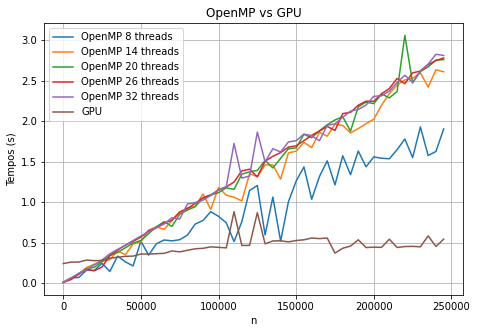

In [440]:
plt.figure(figsize=(7.5, 5))
plt.plot(tamanhos_OP_8threads, tempos_OP_8threads, label='OpenMP 8 threads')
plt.plot(tamanhos_OP_14threads, tempos_OP_14threads, label='OpenMP 14 threads')
plt.plot(tamanhos_OP_20threads, tempos_OP_20threads, label='OpenMP 20 threads')
plt.plot(tamanhos_OP_26threads, tempos_OP_26threads, label='OpenMP 26 threads')
plt.plot(tamanhos_OP_32threads, tempos_OP_32threads, label='OpenMP 32 threads')
plt.plot(tamanhos_GPU, tempos_GPU, label='GPU')
plt.title('OpenMP vs GPU')
plt.xlabel('n')
plt.ylabel('Tempos (s)')
plt.grid('on')
plt.legend()
plt.show()

O gráfico acima constata que de maneira geral, 8 threads parece ser um valor ideal para número máximo, visto que conforme esse número aumenta, pior o desempenho do código. Apesar de que inicialmente todas têm um desempenho similar, pode-se observar as disparidades conforme o tamanho da entrada aumenta. Além disso, similarmente à questão 1, pode-se observar um ponto de saturação em que o aumento do número de threads parece não fazer muito diferença no desempenho, provavelmente porque muitas delas ficam ociosas sendo que o código pode não necessitar todas elas. 

#### Conclusão:

Para entradas pequenas, os códigos OpenMP, com tamanhos variados de threads, todos apresentam desempenho superior à GPU. Isso pode ser explicado devido ao fenômeno de priorização de throughput por conta da GPU. Acessos à memória e a transferência de dados entre CPU e GPU são demorados, e como os códigos OpenMP utilizam apenas CPU, fazendo uso da arquitetura multicore do computador que roda o executável, faz sentido que eles apresentem um melhor desempenho; pois neles a latência é priorizada. No entanto, para entradas maiores, pode-se verificar que a GPU apresenta um desempenho vastamente superior. Seguindo a mesma linha de raciocínio desenvolvida anteriormente, isso se dá que porque a GPU é boa em executar muitas coisas ao mesmo tempo, não importando muito se cada uma dessas instruções é feita de maneira rápida individualmente. Por isso, ao ocupar a GPU ao máximo e pedir pra ela fazer a conta do SaxPy (que é simples), para entradas maiores ela vai se sobressair muito em relação aos códigos que utilizam OpenMP.

**FEEDBACK QUESTÃO 2**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

**QUESTÃO 3.** Resolva a questão 3 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

#### Geração de código e executável

In [441]:
 %%writefile Questao3.cu

#include <random>
#include <iostream>
#include <vector>
#include <thrust/random.h>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/iterator/counting_iterator.h>
using namespace std;

struct is_one
{
  __host__ __device__
  bool operator()(const int &x)
  {
    return x & 1;
  }
};

struct square 
{
    __device__ __host__
    double operator()(const double &x) {
        return x*x;
    }
};

struct rng_gpu {
    __device__ __host__
    double operator() (const int &i) {
        thrust::default_random_engine generator(i*10000000);
        thrust::uniform_real_distribution<double> distribution(0.0, 1.0);
        return distribution(generator);
    }
};

int main () {

    long N = 100000000L;
    thrust::host_vector<double> dotsCPU(2*N);
    thrust::device_vector<double> dots(dotsCPU);
    
    thrust::transform(
        thrust::make_counting_iterator<int>(0),
        thrust::make_counting_iterator<int>(2*N),
        dots.begin(),
        rng_gpu()
    );

    thrust::transform(
        dots.begin(),
        dots.end(),
        dots.begin(),
        square()
    );

    thrust::device_vector<double> squareSum(N);
    thrust::transform(
        dots.begin(),
        dots.begin() + N/2,
        dots.begin() + N/2 + 1,
        squareSum.begin(),
        thrust::plus<double>()  
    );

    thrust::constant_iterator<double> one(1.0);
    thrust::device_vector<double> lessEqual(N);
    thrust::transform(
        squareSum.begin(),
        squareSum.end(),
        one,
        lessEqual.begin(),
        thrust::less_equal<double>()
    );

    
    int result = thrust::count_if(
        lessEqual.begin(),
        lessEqual.end(),
        is_one()
    );

    cout << 4.0 * result/N;

    
  
  }

Writing Questao3.cu


In [442]:
!nvcc -Wno-deprecated-gpu-targets -arch=sm_37 -std=c++14 -o Questao3 Questao3.cu

In [443]:
!./Questao3

tcmalloc: large alloc 1600004096 bytes == 0x55bf5a8d6000 @  0x7f8c843f6887 0x55bf58287be0 0x55bf58280291 0x55bf5827faf5 0x55bf58274e0f 0x55bf5827470f 0x55bf5827359c 0x55bf58272c57 0x55bf5826ecc4 0x7f8c83425c87 0x55bf5826e91a
3.63789

OBS: Não consegui fazer funcionar com `transform_reduce`, então utilizei uma alternativa que é o `count_if`, e percebi grandes melhorias em desempenho do que se fizesse de outra forma (depois de gerar os vetores aleatórios) como a demonstrada abaixo, que demora muito para rodar para o valor de `N`   estabelecido no enunciado: 

```
 for (long i = 0; i < N; i++) {
        double x, y;
      
        x = dots[i];
        y = dots[2*i];
        if (x*x + y*y <= 1) {
            sum++;
        }
    }
    

    double pi = 4.0 * sum / N;
    cout << pi << endl;
    cout << sum << endl;
```

**FEEDBACK QUESTÃO 3**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

**QUESTÃO 4.** Resolva a questão 4 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

#### Função para gerar entradas de um int e duas strings

In [444]:
def programa(a, b, c):
  f = open(f'./in.txt', 'w')
  line = str(a) + '\n' + b + '\n' + c
  f.writelines(line)
  f.close()  

In [445]:
%%writefile Questao4.cu

#include <random>
#include <iostream>
#include <vector>
#include <thrust/random.h>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/iterator/counting_iterator.h>
#include<cstring>
#include <string.h>
using namespace std;

struct calculoScore {
    thrust::device_ptr<char> subA;
    thrust::device_ptr<char> subB;

    calculoScore(thrust::device_ptr<char> subA_, thrust::device_ptr<char> subB_) :
      subA(subA_),
      subB(subB_) {};

    __device__ __host__
    int operator() (const int &i) {
        int score = (subA[i] == subB[i] ? 2 : -1);
        return score;
    }
};

int main () {
    int k;
    string a, b;

    cin >> k >> a >> b;

    thrust::device_vector<char> seqA(a.begin(), a.end());
    thrust::device_vector<char> seqB(b.begin(), b.end());
    thrust::device_vector<int> result(3);


    int num_iter = k / 3;

    thrust::device_vector<int> scoresParesK(num_iter);

    for(int i = 0; i < num_iter; i++) {
        if(i == 0) {
            thrust::transform(
                thrust::make_counting_iterator<int>(0),
                thrust::make_counting_iterator<int>(3),
                result.begin(),
                calculoScore(seqA.data(), seqB.data())
            );
        } else {
            thrust::transform(
                thrust::make_counting_iterator<int>(i*3),
                thrust::make_counting_iterator<int>(i*3 + 3),
                result.begin(),
                calculoScore(seqA.data(), seqB.data())
            );   
        }

        scoresParesK[i] = thrust::reduce(
            result.begin(),
            result.end(),
            0.0f, 
            thrust::plus<int>()  
        );
    }

    int maxScore = thrust::reduce(
        scoresParesK.begin(),
        scoresParesK.end(),
        0.0f,
        thrust::maximum<int>()
    );

    cout << maxScore << endl;

    

    return 0;
}

Writing Questao4.cu


In [446]:
!nvcc -Wno-deprecated-gpu-targets -arch=sm_37 -std=c++14 -o Questao4 Questao4.cu

In [447]:
programa(6, "ATCCGATCC", "ATCGGTCAA")
!./Questao4 < in.txt

6


**FEEDBACK QUESTÃO 4:** Não preencher este campo. Ele será preenchido pelo seu professor durante a correção.